In [ ]:
%pip install open_clip_torch
%pip install clip-retrieval
%pip install img2dataset
%pip install  torch
%pip install  transformers
%pip install  accelerate
%pip install  datasets
%pip install  holoviews
%pip install ftfy regex tqdm
%pip install transformers==4.45.2 sentence-transformers==3.1.1


In [ ]:
%pip install git+https://github.com/openai/CLIP.git
%pip install wandb

In [ ]:
%pip install  umap-learn
%pip install  datashader
%pip install  bokeh
%pip install  holoviews scikit-image colorcet dask[dataframe]

In [ ]:
%pip install scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import pandas as pd
from datasets import load_dataset,Dataset, concatenate_datasets
import numpy as np
from time import process_time
import math
import random
import joblib
import tqdm

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

/home/kaba4ok/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### *DATASET PROCESSING*

In [27]:
dataset = load_dataset("csv", data_files="./tcc_ceds_music.csv")
dataset = dataset.remove_columns(["artist_name", "track_name"])
dataset = dataset.rename_columns({"genre":"label", "lyrics":"sentence"})

In [28]:
unique_genres = dataset['train'].unique('label')
genre_to_index = {label: idx for idx, label in enumerate(unique_genres)}

def label_to_index_func(data_set):
    data_set['label'] = genre_to_index[data_set['label']]
    return data_set

dataset = dataset.map(label_to_index_func)

In [29]:
genre_idx_delimiters = []
prev_genre = -1

for i in range(len(dataset['train'])):
  genre_idx = int(dataset['train'][i]['label'])
  if genre_idx != prev_genre:
    genre_idx_delimiters.append(i)
    prev_genre = genre_idx

### TF-IDF PART

In [52]:
def remove_repetitions(song:str):
    clean_song = set()

    for word in song.split():
        if not word in clean_song:
            clean_song.add(word)

    return " ".join(list(clean_song))

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

lyrics_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.015, use_idf=True, lowercase=True, smooth_idf=True)
lyrics_tfidf = lyrics_vectorizer.fit_transform([remove_repetitions(song) for song in dataset['train']['sentence']])

print(lyrics_tfidf.shape)

(28372, 475)


In [93]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

truncation_length = 60
svd_reduction = make_pipeline(TruncatedSVD(n_components=truncation_length), Normalizer(copy=False))
reduced_lyrics_tfidf = svd_reduction.fit_transform(lyrics_tfidf)

explained_variance = svd_reduction[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD: {explained_variance * 100:.1f}%")
print(reduced_lyrics_tfidf.shape)

Explained variance of the SVD: 25.4%
(28372, 60)


<Axes: >

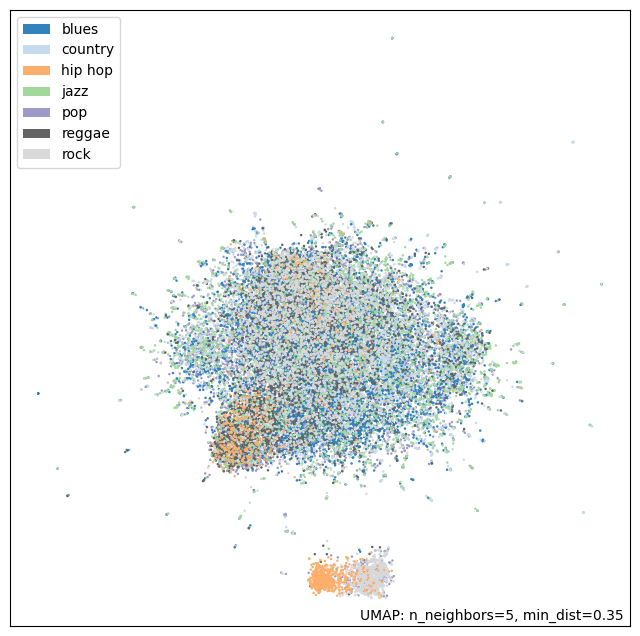

In [86]:
import umap
import umap.plot

metric = 'euclidean'

dim_reducer = umap.UMAP( n_neighbors=5,
      min_dist=0.35,
      n_components=2,
      metric=metric
)
pure_reductions = dim_reducer.fit(reduced_lyrics_tfidf)
umap.plot.points(pure_reductions, labels=np.array([unique_genres[i] for i in dataset['train']['label']]), theme='green', show_legend=True)

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

best_k_means = None
best_homogenity = 0.0
best_completeness = 0.0

r_start = np.random.randint(1,100)
r_end = np.random.randint(r_start + 25, r_start + 60)

for clustering_seed in range(r_start, r_end):
    lyrics_clusterizer = KMeans(n_clusters=len(unique_genres), max_iter=1500, random_state=clustering_seed, n_init=3)
    lyrics_clusterizer.fit(reduced_lyrics_tfidf)

    hom_score = metrics.homogeneity_score(dataset['train']['label'], lyrics_clusterizer.labels_)
    comp_score = metrics.completeness_score(dataset['train']['label'], lyrics_clusterizer.labels_)

    print("Homogenity score: ", hom_score)
    print("Completeness score: ", comp_score)
    print("V-metric score: ", metrics.v_measure_score(dataset['train']['label'], lyrics_clusterizer.labels_ ,beta=0.85))

    if(hom_score > best_homogenity):
        best_homogenity = hom_score
        best_k_means = lyrics_clusterizer
    if(comp_score > best_completeness):
        best_completeness = comp_score
        best_k_means = lyrics_clusterizer

print(f"Best homogenity score: {best_homogenity}")
print(f"Best completeness score: {best_completeness}")


### TF-IDF ESTIMATOR PART

In [94]:
batch_size = 5

#transforms the training embedding data into torch-compliant format

labels = dataset['train']['label']
sparse_labels = []
for genre_label in labels:
  sparse_arr = [0 for i in range(len(unique_genres))]
  sparse_arr[genre_label] = 1
  sparse_labels.append(sparse_arr)

features_tensor = torch.tensor(reduced_lyrics_tfidf, dtype=torch.float32)
labels_tensor = torch.tensor(sparse_labels, dtype=torch.float32)

dataset_train = torch.utils.data.TensorDataset(features_tensor, labels_tensor)
train_data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

#transforms the testing embedding data into torch-compliant format

test_size = 10000
rand_indices = np.random.randint(0, len(dataset['train']), size=test_size)

features_lyrics = reduced_lyrics_tfidf[rand_indices]
labels = dataset['train'][rand_indices]['label']

features_tensor = torch.tensor(features_lyrics, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int32)

dataset_test = torch.utils.data.TensorDataset(features_tensor, labels_tensor)
test_data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [89]:
#nn for tf-idf analysis, as Kmeans is incapable of clearly grouping the features vectors

class NeuralTFIDF(nn.Module):
    def __init__(self, tfidf_vector_size:int):
        super(NeuralTFIDF, self).__init__()

        self.lyrics_layer_0 = nn.Linear(int(tfidf_vector_size), int(tfidf_vector_size/2)) 
        self.lyrics_layer_1 = nn.Linear(int(tfidf_vector_size/2), int(tfidf_vector_size/3))
        self.lyrics_layer_2 = nn.Linear(int(tfidf_vector_size/3), len(unique_genres))
    
    def forward(self, x):
        x = F.relu(self.lyrics_layer_0(x))
        x = F.relu(self.lyrics_layer_1(x))
        x = F.relu(self.lyrics_layer_2(x))

        return x

In [ ]:
nn_tfidf = NeuralTFIDF(truncation_length)
loss_alg = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_tfidf.parameters(), lr=0.001, betas=(0.9, 0.99))

for epoch in range(10):

    current_loss = 0.0

    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = nn_tfidf(inputs)
        loss = loss_alg(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        if i % 500 == 499:
            print(f'Mean loss for [{epoch + 1}, {i + 1:5d}] : {current_loss / 500:.3f}')
            current_loss = 0.0

torch.save(nn_tfidf.state_dict(), "./trained-nn-tfidf.pth")

In [97]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_data_loader:
        inputs, labels = data
        outputs = nn_tfidf(inputs)

        value, predicted_classes = torch.max(outputs.data, 1)
        
        # print("\nEstimates : ", outputs.data)
        # print("Genre classification : ", predicted_classes)
        # print("Expected : ", labels)

        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()

print(f'Accuracy for 10000 test tf-idf vectors: {100 * correct // total} %')

Accuracy for 10000 test tf-idf vectors: 36 %


### *COVER EMBEDDING PART*

In [10]:
cover_dataset_source_path = "/content/drive/MyDrive/AIDatasets/retrieved_covers.zip"
cover_extraction_directory = "./retrieved_covers"
cover_embeddings_root_path = "./cover_embeddings"

In [ ]:
!unzip {cover_dataset_source_path} -d ./

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import clip
from PIL import Image
clip_model = "open_clip:ViT-B-32/laion2b_s34b_b79k"

In [ ]:
!clip-retrieval inference --input_dataset {cover_extraction_directory} --output_folder {cover_embeddings_root_path} --enable_wandb True --clip_model {clip_model}

In [ ]:
#covers for some songs have not been retrieved, so from now on we are effectively workign with a subset of the input dataset
available_song_indices = []
genres = []

for filename in sorted(os.listdir(cover_extraction_directory)):
    entry_idx = int(filename.split('_')[0])
    available_song_indices.append(entry_idx)
    genres.append(dataset['train'][entry_idx]['label'])


In [ ]:
covers_embeddings = np.load(f"{cover_embeddings_root_path}/img_emb/img_emb_0.npy")

In [ ]:
covers_embeddings_df = pd.DataFrame(covers_embeddings)
covers_embeddings_df['genres'] = genres

In [ ]:
joblib.dump(covers_embeddings_df, "embeddings_of_all_covers.pkl")

In [14]:
covers_embeddings_df = joblib.load("embeddings_of_all_covers.pkl")

In [28]:
cover_embedding_size = covers_embeddings_df.shape[1] - 1

### *LYRICS EMBEDDER PART*

In [ ]:
from sentence_transformers import SentenceTransformer,SentenceTransformerTrainingArguments
from sentence_transformers.losses import BatchAllTripletLoss, BatchHardSoftMarginTripletLoss, BatchHardTripletLoss
from sentence_transformers.trainer import SentenceTransformerTrainer
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator

In [ ]:
model = SentenceTransformer("sentence-transformers/all-distilroberta-v1")

In [ ]:
# populate with permuted lyrics
n_songs_to_permute = len(dataset['train'])
n_permutations = 4

permuted_lyrics = []
lables_of_permuted = []

for i in range(n_songs_to_permute):
    song_item = dataset['train'][i]
    label = song_item['label']
    sentence = song_item['sentence'].split(' ')

    for ii in range(n_permutations):
        permuted_song = " ".join(random.sample(sentence, len(sentence)))
        permuted_lyrics.append(permuted_song)
        lables_of_permuted.append(label)

permuted_dataset = Dataset.from_dict({"sentence":permuted_lyrics, "label":lables_of_permuted})
dataset['train'] = concatenate_datasets([dataset['train'], permuted_dataset])

In [ ]:
train_test_split = dataset['train'].train_test_split(test_size=0.05)

In [ ]:
loss = BatchHardTripletLoss(model,margin=7)
training_args = SentenceTransformerTrainingArguments(
    output_dir="./models/guesser_2",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-6,
    warmup_ratio=0.15,
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.01,
    use_cpu=False,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    save_steps=100,
    save_total_limit=2,
    logging_steps=50,
    seed=135)

In [ ]:
train_set = train_test_split['train']
trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=train_set,
    loss=loss,
    args=training_args
)

trainer.train()

In [ ]:
#save the embedding model
model.save_pretrained("trained-embedder-permute")
! tar -czf trained_embedder.tar.gz ./trained-embedder-permute

In [ ]:
#creates test dataset to evaluate the embedder

from collections import defaultdict
import random

class_groups = defaultdict(list)
for example in train_test_split['test']:
    class_groups[example['label']].append(example['sentence'])

triplets = []

for label, sentences in class_groups.items():
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            anchor = sentences[i]
            positive = sentences[j]

            negative_label = random.choice([lbl for lbl in class_groups.keys() if lbl != label])
            negative = random.choice(class_groups[negative_label])

            triplets.append({
                'anchor': anchor,
                'positive': positive,
                'negative': negative
            })

triplet_test_dataset = Dataset.from_list(triplets)
triplet_test_dataset = triplet_test_dataset.shuffle(seed=83)

print(triplet_test_dataset)

In [ ]:
test_evaluator = TripletEvaluator(
    anchors=triplet_test_dataset["anchor"],
    positives=triplet_test_dataset["positive"],
    negatives=triplet_test_dataset["negative"],
    name="all-test",
)
print(test_evaluator(model))

In [ ]:
#load the saved embedding model
! tar -xzf ./trained_embedder_permute.tar.gz ./
model = SentenceTransformer("trained-embedder")

In [17]:
def get_lyrics_embedding(lyrics:str):
  return model.encode([lyrics.lower()])


In [18]:
embedding_size = model.get_sentence_embedding_dimension()

### *COVER+LYRICS ESTIMATOR PART*

In [ ]:
#creates a dataframe of all songs as embeddings -> genre as idx

lyrics_embeddigs = []
genres = []
unique_genres_set = set()

import string
songs_and_lyrics = pd.read_csv('./tcc_ceds_music.csv')

for idx in range(len(songs_and_lyrics)):
  genre = songs_and_lyrics["genre"][idx]
  unique_genres_set.add(genre)

  lyrics_as_bag_of_words_string = str(songs_and_lyrics["lyrics"][idx])

  embedding =  get_lyrics_embedding(lyrics_as_bag_of_words_string)[0]
  lyrics_embeddigs.append(embedding)
  genres.append(genre)

embedding_set = pd.DataFrame({"genres":genres})
embeddings_list = []

for i in range(embedding_size):
  dim_i = pd.Series([embedding[i] for embedding in lyrics_embeddigs])
  embeddings_list.append(dim_i)

embeddings_df = pd.concat(embeddings_list, axis=1)
embedding_set = pd.concat([embeddings_df, embedding_set], axis=1)

embedding_set['genres'] = embedding_set['genres'].apply(lambda genre: genre_to_index[genre])

In [ ]:
#save embeddings of all songs
joblib.dump(embedding_set, "embedding_set_of_all_songs_permute.pkl")

In [19]:
#load the embeddigns of al songs
embedding_set = joblib.load("embedding_set_of_all_songs_permute.pkl")

In [ ]:
#dimensionality reduction for lyrics embeddings
import umap
import umap.plot

ifReduceDimensionality = False
reductionFactor = 2
metric = 'euclidean'

ifPlotReduced = False

if ifPlotReduced:
  actual_embedding_set = embedding_set.iloc[:, :-1]

  dim_reducer = umap.UMAP( n_neighbors=5,
        min_dist=0.2,
        n_components=2,
        metric=metric
  )
  pure_reductions = dim_reducer.fit(actual_embedding_set)
  umap.plot.points(pure_reductions, labels=np.array([unique_genres[i] for i in embedding_set['genres']]), theme='green', show_legend=True)

if ifReduceDimensionality:
  actual_embedding_set = embedding_set.iloc[:, :-1]

  embedding_size_reduced = int(embedding_size / reductionFactor)

  dim_reducer = umap.UMAP( n_neighbors=10,
        min_dist=0.15,
        n_components=embedding_size_reduced,
        metric=metric
  )
  reduced_embeddings = pd.DataFrame(dim_reducer.fit_transform(actual_embedding_set), columns = [i for i in range(embedding_size_reduced)])
  print(reduced_embeddings.shape)
  reduced_embeddings['genres'] = embedding_set['genres']

  embedding_size = embedding_size_reduced
  embedding_set = reduced_embeddings
  print(reduced_embeddings.head(15))



In [20]:
batch_size = 4
#transforms the training embedding data into torch-compliant format. selects only data items for whom both cover and lyrics are available.

features_lyrics = embedding_set.iloc[available_song_indices, :-1].values
features_covers = covers_embeddings_df.iloc[:, :-1].values

features_combined = np.concatenate((features_lyrics, features_covers), axis=1)

labels = embedding_set.iloc[available_song_indices, -1].values
sparse_labels = []
for genre_label in labels:
  sparse_arr = [0 for i in range(len(unique_genres))]
  sparse_arr[genre_label] = 1
  sparse_labels.append(sparse_arr)

features_tensor = torch.tensor(features_combined, dtype=torch.float32)
labels_tensor = torch.tensor(sparse_labels, dtype=torch.float32)

dataset_train = torch.utils.data.TensorDataset(features_tensor, labels_tensor)

train_data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

#transforms the testing embedding data into torch-compliant format

test_size = 10000
rand_indices_local = np.random.randint(0, len(available_song_indices), size=test_size)
rand_indices_absolute = [available_song_indices[i] for i in rand_indices_local] #indirect indexing

features_lyrics = embedding_set.iloc[rand_indices_absolute, :-1].values
features_covers = covers_embeddings_df.iloc[rand_indices_local, :-1].values
labels = embedding_set.iloc[rand_indices_absolute, -1].values

features_combined = np.concatenate((features_lyrics, features_covers), axis=1)

features_tensor = torch.tensor(features_combined, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.int32)

dataset_test = torch.utils.data.TensorDataset(features_tensor, labels_tensor)

test_data_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [67]:
#the nn used for genre estimation
#now receives 768 from lyrics and 512 from cover packed into x

# class NeuralGuesser40Conv(nn.Module):
#     def __init__(self, embedding_size:int):
#         super().__init__()
#         self.num_conv_output_channels = 3

#         self.pre_conv1 = nn.Conv1d(1,self.num_conv_output_channels,7,stride=1,padding="same")
#         self.prelu_weights = nn.Parameter(torch.ones(self.num_conv_output_channels))

#         # self.layer0 = nn.Linear(int(embedding_size), int(embedding_size/2))

#         self.layer0 = nn.Linear(int(embedding_size * self.num_conv_output_channels), int(embedding_size/2))
#         self.layer1 = nn.Linear(int(embedding_size/2), int(embedding_size/3))
#         # self.layerExp = nn.Linear(int(embedding_size/3), embedding_size)
#         self.layer2 = nn.Linear(int(embedding_size/3), int(embedding_size/6))
#         self.layer3 = nn.Linear(int(embedding_size/6), int(embedding_size/12))

#         self.layer4 = nn.Linear(int(embedding_size/12), len(unique_genres))

#     def forward(self, x):
#         x = F.prelu(self.pre_conv1(x), self.prelu_weights)
#         x = torch.flatten(x,1)

#         x = F.relu(self.layer0(x))
#         x = F.relu(self.layer1(x))
#         # x = F.relu(self.layerExp(x))
#         x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
#         x = self.layer4(x)

#         return x

class NeuralGuesser(nn.Module):
    def __init__(self, lyrics_embedding_size:int, covers_embedding_size:int, first_common_dimension:int):
        super(NeuralGuesser, self).__init__()

        self.les = lyrics_embedding_size
        self.ces = covers_embedding_size

        #lyrics layers
        self.lyrics_layer_0 = nn.Linear(int(lyrics_embedding_size), int(lyrics_embedding_size/2)) #maybe init with prelu
        self.lyrics_layer_1 = nn.Linear(int(lyrics_embedding_size/2), int(lyrics_embedding_size/3))
        self.lyrics_layer_2 = nn.Linear(int(lyrics_embedding_size/3), int(lyrics_embedding_size/6))
        self.lyrics_layer_3 = nn.Linear(int(lyrics_embedding_size/6), first_common_dimension)

        #cover layers
        num_out_conv_channels = 32
        kernel_size = 4
        averaging_kernel_size = 4

        # self.cover_layers_0 = nn.Conv1d(1,num_out_conv_channels, kernel_size, stride=kernel_size) #gives me length of covers_embedding_size/kernel_size (64)
        # self.prelu_weights = nn.Parameter(torch.ones(num_out_conv_channels))
        # self.cover_layers_1 = nn.AvgPool1d(averaging_kernel_size, averaging_kernel_size) #flatten before this

        # effective_tensor_length = int((num_out_conv_channels * (covers_embedding_size/kernel_size)) / averaging_kernel_size)
        # self.cover_layers_2 = nn.Linear(effective_tensor_length, int(effective_tensor_length/2))
        # self.cover_layers_3 = nn.Linear(int(effective_tensor_length/2), first_common_dimension)

        self.cover_layers_0 = nn.Linear(int(covers_embedding_size), int(covers_embedding_size/2)) #maybe init with prelu
        self.cover_layers_1 = nn.Linear(int(covers_embedding_size/2), int(covers_embedding_size/3))
        self.cover_layers_2 = nn.Linear(int(covers_embedding_size/3), first_common_dimension)

        #common layers
        num_final_conv_channels = 8
        final_kernel_size = 4

        self.common_layer_0 = nn.Conv1d(2, num_final_conv_channels, final_kernel_size, stride=final_kernel_size) #maybe pool average

        self.common_layer_1 = nn.Linear(int(num_final_conv_channels * (first_common_dimension / final_kernel_size)), first_common_dimension) #flatten before this
        # self.common_layer_1 = nn.Linear(2 * first_common_dimension, first_common_dimension) #flatten before this
        self.common_layer_2 = nn.Linear(first_common_dimension,int(first_common_dimension/2))
        self.common_layer_3 = nn.Linear(int(first_common_dimension/2), len(unique_genres))

    def forward(self, x):
        lyrics_part = x[:, :self.les]

        cover_part = x[:, self.les:]
        # cover_part = cover_part[:,None,:] #adding a dimension to be able to feed it through convolution

        # print("Lyrics initial part shape:", lyrics_part.shape)
        # print("Cover initial part shape:", cover_part.shape)

        #lyrics forward
        lyrics_part = F.silu(self.lyrics_layer_0(lyrics_part))
        lyrics_part = F.relu(self.lyrics_layer_1(lyrics_part))
        lyrics_part = F.relu(self.lyrics_layer_2(lyrics_part))
        lyrics_part = F.relu(self.lyrics_layer_3(lyrics_part))

        #cover forward
        # cover_part = F.prelu(self.cover_layers_0(cover_part), self.prelu_weights)
        # cover_part = torch.flatten(cover_part,1) #flattening
        # cover_part = self.cover_layers_1(cover_part) #averaging
        # cover_part = F.relu(self.cover_layers_2(cover_part))
        # cover_part = F.relu(self.cover_layers_3(cover_part))

        cover_part = F.silu(self.cover_layers_0(cover_part))
        cover_part = F.relu(self.cover_layers_1(cover_part))
        cover_part = F.relu(self.cover_layers_2(cover_part))

        #combining parts
        # print("Lyrics merge part shape:", lyrics_part.shape)
        # print("Cover merge part shape:", cover_part.shape)

        x = torch.stack([lyrics_part, cover_part], dim=0) #maps channel -> batch -> embedding
        x = torch.permute(x, (1,0,2)) #now maps batch -> channel -> embedding

        # print("Two-channel merged tensor shape:", x.shape)

        x = F.leaky_relu(self.common_layer_0(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.common_layer_1(x))
        x = F.relu(self.common_layer_2(x))
        x = F.relu(self.common_layer_3(x))

        return x

In [ ]:
#training the nn
class_weights = torch.tensor(np.array([0.1282, 0.1357,0.1398, 0.1436, 0.1505, 0.1426, 0.1592]), dtype=torch.float32) #as I computed from the entire dataset

guesser = NeuralGuesser(embedding_size, cover_embedding_size, 128)
loss_alg = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(guesser.parameters(), lr=0.0005, betas=(0.9, 0.99))

for epoch in range(10):

    current_loss = 0.0

    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data

        # print("Inputs shape:", inputs.shape)
        # print("Labels shape:", labels.shape)

        optimizer.zero_grad()
        outputs = guesser(inputs)
        loss = loss_alg(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        if i % 500 == 499:
            print(f'Mean loss for [{epoch + 1}, {i + 1:5d}] : {current_loss / 500:.3f}')
            current_loss = 0.0

torch.save(guesser.state_dict(), "./trained-nn.pth")

In [69]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_data_loader:
        inputs, labels = data
        outputs = guesser(inputs)

        value, predicted_classes = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()

print(f'Accuracy for 10000 test songs: {100 * correct // total} %')

Accuracy for 10000 test songs: 63 %


### *INPUT LYRICS PROCESSING PART*

In [ ]:
%pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer as wnl
import string

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
part_of_speech_mapper = {
    'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n',
    'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',
    'JJ': 'a', 'JJR': 'a', 'JJS': 'a',
    'RB': 'r', 'RBR': 'r', 'RBS': 'r',
    'PDT': 'a',
    'WRB': 'r',
    '$': None, "''": None, '(': None, ')': None, ',': None, '--': None, '.': None,
    ':': None, 'CC': None, 'CD': None, 'DT': None, 'EX': None, 'FW': None, 'IN': None,
    'LS': None, 'MD': None, 'POS': None, 'PRP': None, 'PRP$': None, 'RP': None,
    'SYM': None, 'TO': None, 'UH': None, 'WDT': None, 'WP': None, 'WP$': None,
    '``': None,
}

In [ ]:
stop_words = set(stopwords.words('english'))
symbols = set([",",".","/","#","*","(",")","?","+","=",":",";","%","[", "]"])
song_specific = set(["chorus", "repeat", "verse", "oh", "ooh", "ah", "aah"])

def check_if_not_to_be_removed(token:str):
  return (not token.lower() in stop_words) and (not token.lower() in symbols) and (not token.lower() in song_specific) and (not any(char.isdigit() for char in token)) and (not "'" in token)

def transform_lyrics(lyrics:str):
  tokenized_lyrics = word_tokenize(lyrics)

  tagged_lyrics = nltk.pos_tag(tokenized_lyrics)
  lemmatized_lyrics = [wnl().lemmatize(word.lower(), pos=part_of_speech_mapper[assumed_pos]) for word,assumed_pos in tagged_lyrics if part_of_speech_mapper[assumed_pos] != None]
  filtered_lyrics = [w.lower() for w in lemmatized_lyrics if check_if_not_to_be_removed(w)]


  deduplicated_lyrics = set()
  for word in filtered_lyrics:
    if not word in deduplicated_lyrics :
      deduplicated_lyrics.add(word)

  deduplicated_lyrics = ' '.join(list(deduplicated_lyrics))    

  print("Tokenized lyrics:", ' '.join(tokenized_lyrics))
  print("Lemmatized lyrics:", ' '.join(lemmatized_lyrics))
  print("Transformed lyrics:", deduplicated_lyrics)

  return deduplicated_lyrics

### INTERFACE

In [ ]:
def map_estimates_vector_to_genre(estimates_vector):
    value, genre = torch.max(estimates_vector, 1)

    #map to the actual genre
    for key,item in genre_to_index.items():
        if genre == item:
            return key

    return -1

In [ ]:
#deprecated in favor of lyrics+cover
def estimate_genre_lyrics(model, song_lyrics):
  filtered_lyrics = transform_lyrics(song_lyrics)

  embedding = get_lyrics_embedding(filtered_lyrics)
  model_prompt = torch.tensor(embedding, dtype=torch.float32)[:,None,:] #only if using convolutional layer

  #get estimate here
  prediction = model(model_prompt)

  return map_estimates_vector_to_genre(prediction)


In [ ]:
def get_combined_estimate_vector(model, song_lyrics, cover_path) -> torch.tensor:
  filtered_lyrics = transform_lyrics(song_lyrics)

  #todo: check these heavily
  
  lyrics_embedding = get_lyrics_embedding(filtered_lyrics)[0]
  # model_prompt = torch.tensor(embedding, dtype=torch.float32)

  !clip-retrieval inference --input_dataset {cover_path} --output_folder {cover_path}/emb --clip_model {clip_model}
  cover_embedding = np.load(f"{cover_path}/emb/img_emb/img_emb_0.npy")[0]

  model_prompt = [np.concatenate((lyrics_embedding, cover_embedding), axis=1)]

  #get estimate here
  prediction = model(model_prompt) 

  return prediction   

In [ ]:
def estimate_genre_lyrics_and_cover(model, song_lyrics, cover_path):
  prediction = get_combined_estimate_vector(model, song_lyrics, cover_path)

  return map_estimates_vector_to_genre(prediction)

In [ ]:
def get_tfidf_estimate(song_lyrics, tfidf_nn, tfidf_vectorizer, tfidf_reducer) -> torch.tensor:
    tfidf_vector = tfidf_vectorizer.transform([song_lyrics])
    reduced_tfidf_vector = tfidf_reducer.transform(tfidf_vector)
    estimation_vector = tfidf_nn(reduced_tfidf_vector)

    return estimation_vector

In [ ]:
def estimate_genre_lyrics_cover_tfidf(combined_nn, tfidf_nn, tfidf_vectorizer, tfidf_reducer, song_lyrics, cover_path):
    combined_nn_estimate = get_combined_estimate_vector(combined_nn,song_lyrics,cover_path)
    tfidf_estimate = get_tfidf_estimate(song_lyrics, tfidf_nn, tfidf_vectorizer, tfidf_reducer)

    #todo: check these heavily
    combined_nn_estimate = torch.nn.functional.normalize(combined_nn_estimate,dim=1)
    tfidf_estimate = torch.nn.functional.normalize(tfidf_estimate,dim=1)

    estimates_sum = combined_nn_estimate + tfidf_estimate

    return map_estimates_vector_to_genre(estimates_sum)

    

### *EXPERIMENTS PART*

In [ ]:
lyrics="Ooh You can dance You can jive Having the time of your life Ooh, see that girl Watch that scene Digging the dancing queen Friday night and the lights are low Looking out for a place to go Where they play the right music Getting in the swing You come to look for a king Anybody could be that guy Night is young and the music's high With a bit of rock music Everything is fine You're in the mood for a dance And when you get the chance You are the dancing queen Young and sweet Only seventeen Dancing queen Feel the beat from the tambourine, oh yeah You can dance You can jive Having the time of your life Ooh, see that girl Watch that scene Digging the dancing queen You're a teaser, you turn 'em on Leave 'em burning and then you're gone Looking out for another Anyone will do You're in the mood for a dance And when you get the chance You are the dancing queen Young and sweet Only seventeen Dancing queen Feel the beat from the tambourine, oh yeah You can dance You can jive Having the time of your life Ooh, see that girl Watch that scene Digging the dancing queen Digging the dancing queen"
print(estimate_genre_lyrics(guesser, lyrics))

Tokenized lyrics: Ooh You can dance You can jive Having the time of your life Ooh , see that girl Watch that scene Digging the dancing queen Friday night and the lights are low Looking out for a place to go Where they play the right music Getting in the swing You come to look for a king Anybody could be that guy Night is young and the music 's high With a bit of rock music Everything is fine You 're in the mood for a dance And when you get the chance You are the dancing queen Young and sweet Only seventeen Dancing queen Feel the beat from the tambourine , oh yeah You can dance You can jive Having the time of your life Ooh , see that girl Watch that scene Digging the dancing queen You 're a teaser , you turn 'em on Leave 'em burning and then you 're gone Looking out for another Anyone will do You 're in the mood for a dance And when you get the chance You are the dancing queen Young and sweet Only seventeen Dancing queen Feel the beat from the tambourine , oh yeah You can dance You can 

In [ ]:
lyrics="Half past twelve And I'm watchin' the late show in my flat, all alone How I hate to spend the evening on my own Autumn winds Blowin' outside the window as I look around the room And it makes me so depressed to see the gloom There's not a soul out there No one to hear my prayer Gimme, gimme, gimme a man after midnight Won't somebody help me chase these shadows away? Gimme, gimme, gimme a man after midnight Take me through the darkness to the break of the day Movie stars Find the end of the rainbow with a fortune to win It's so different from the world I'm living in Tired of TV I open the window and I gaze into the night But there's nothing there to see, no one in sight There's not a soul out there No one to hear my prayer Gimme, gimme, gimme a man after midnight Won't somebody help me chase these shadows away? Gimme, gimme, gimme a man after midnight Take me through the darkness to the break of the day Gimme, gimme, gimme a man after midnight Gimme, gimme, gimme a man after midnight There's not a soul out there No one to hear my prayer Gimme, gimme, gimme a man after midnight Won't somebody help me chase these shadows away? Gimme, gimme, gimme a man after midnight Take me through the darkness to the break of the day Gimme, gimme, gimme a man after midnight Won't somebody help me chase these shadows away? Gimme, gimme, gimme a man after midnight Take me through the darkness to the break of the day"
print(estimate_genre_lyrics(guesser, lyrics))

Tokenized lyrics: Half past twelve And I 'm watchin ' the late show in my flat , all alone How I hate to spend the evening on my own Autumn winds Blowin ' outside the window as I look around the room And it makes me so depressed to see the gloom There 's not a soul out there No one to hear my prayer Gim me , gim me , gim me a man after midnight Wo n't somebody help me chase these shadows away ? Gim me , gim me , gim me a man after midnight Take me through the darkness to the break of the day Movie stars Find the end of the rainbow with a fortune to win It 's so different from the world I 'm living in Tired of TV I open the window and I gaze into the night But there 's nothing there to see , no one in sight There 's not a soul out there No one to hear my prayer Gim me , gim me , gim me a man after midnight Wo n't somebody help me chase these shadows away ? Gim me , gim me , gim me a man after midnight Take me through the darkness to the break of the day Gim me , gim me , gim me a man af

In [ ]:
lyrics="You'll take my life but I'll take yours, too You'll fire your musket but I'll run you through So when you're waiting for the next attack You'd better stand, there's no turning back The bugle sounds, the charge begins But on this battlefield, no one wins The smell of acrid smoke and horses' breath As I plunge on into certain death Oh Oh The horse he sweats with fear, we break to run The mighty roar of the Russian guns And as we race towards the human wall The screams of pain as my comrades fall We hurdle bodies that lay on the ground And the Russians fire another round We get so near yet so far away We won't live to fight another day Oh Oh We get so close, near enough to fight When a Russian gets me in his sights He pulls the trigger and I feel the blow A burst of rounds take my horse below And as I lay there gazing at the sky My body's numb and my throat is dry And as I lay forgotten and alone Without a tear I draw my parting groan Oh Oh"
print(estimate_genre_lyrics(guesser, lyrics))

Tokenized lyrics: You 'll take my life but I 'll take yours , too You 'll fire your musket but I 'll run you through So when you 're waiting for the next attack You 'd better stand , there 's no turning back The bugle sounds , the charge begins But on this battlefield , no one wins The smell of acrid smoke and horses ' breath As I plunge on into certain death Oh Oh The horse he sweats with fear , we break to run The mighty roar of the Russian guns And as we race towards the human wall The screams of pain as my comrades fall We hurdle bodies that lay on the ground And the Russians fire another round We get so near yet so far away We wo n't live to fight another day Oh Oh We get so close , near enough to fight When a Russian gets me in his sights He pulls the trigger and I feel the blow A burst of rounds take my horse below And as I lay there gazing at the sky My body 's numb and my throat is dry And as I lay forgotten and alone Without a tear I draw my parting groan Oh Oh
Lemmatized lyr

In [ ]:
lyrics="How I've waited for you to come I've been here all alone Now that you've arrived Please stay awhile And I promise I won't keep you long I'll keep you forever (forever, forever, forever) Graze the skin with my fingertips The brush of dead, cold flesh appease the means Provoking images, delicate features so smooth A pleasant fragrance in the light of the moon Dance with the dead in my dreams Listen to their hallowed screams The dead have taken my soul Temptation's lost all control Simple smiles elude psychotic eyes Lose all mind control, rationale declines Empty eyes enslave the creations Of placid faces and lifeless pageants In the depths of a mind insane Fantasy and reality are the same Graze the skin with my fingertips The brush of dead, warm flesh pacifies the means Incised members ornaments on my being Adulating the skin before me Simple smiles elude psychotic eyes Lose all mind control, rationale declines Empty eyes enslave the creations Of placid faces and lifeless pageants Dance with the dead in my dreams (Hello? Hello, Mr. Gein?) Listen to their hallowed screams (Mr. Gein?) The dead have taken my soul (let me out of here, Mr. Gein) Temptation's lost all control (Mr. Gein? I don't want to play anymore, Mr. Gein) Dance with the dead in my dreams (Mr. Gein, this isn't fun anymore) Listen to their hallowed screams (I don't wanna play anymore, Mr. Gein, Mr. Gein?) The dead have taken my soul (I want out of here, Mr. Gein) Temptation's lost all control (let me out now)"
print(estimate_genre_lyrics(guesser, lyrics))

Tokenized lyrics: How I 've waited for you to come I 've been here all alone Now that you 've arrived Please stay awhile And I promise I wo n't keep you long I 'll keep you forever ( forever , forever , forever ) Graze the skin with my fingertips The brush of dead , cold flesh appease the means Provoking images , delicate features so smooth A pleasant fragrance in the light of the moon Dance with the dead in my dreams Listen to their hallowed screams The dead have taken my soul Temptation 's lost all control Simple smiles elude psychotic eyes Lose all mind control , rationale declines Empty eyes enslave the creations Of placid faces and lifeless pageants In the depths of a mind insane Fantasy and reality are the same Graze the skin with my fingertips The brush of dead , warm flesh pacifies the means Incised members ornaments on my being Adulating the skin before me Simple smiles elude psychotic eyes Lose all mind control , rationale declines Empty eyes enslave the creations Of placid f

Adding covers:                            
  What describes a cover?
  + Action ? - a lot of static ones
  + Presence of people ? - rather binary split
  + Present items ? - weakly descriptive
  
  + Simplicity: complicated artwork vs bunch of people + text -> gives a nice hint
  + Art style ?
  + Mood ?
  + Abstractness ?
  + Modernicity ?